In [1]:
import matplotlib.pyplot as plt
import importlib.util
import pandas as pd
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
from crashpy.utilities import crashMemMap
from matplotlib.colors import LogNorm
from matplotlib.colors import Normalize

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell

# pretty print all cell's output and not just the last one
InteractiveShell.ast_node_interactivity = "all"

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

In [5]:
def place_fesc(fesc_arr, threshold=1e-3):
    frac_small = (fesc_arr < threshold).sum()/len(fesc_arr)
    
    fesc_new = np.zeros_like(fesc_arr)
    for i, fesc in enumerate(fesc_arr):
        if fesc < threshold:
            fesc_new[i] = 1.5*threshold+np.random.uniform(-0.5*threshold, 0.5*threshold) 
        else:
            fesc_new[i] = fesc
    return frac_small, fesc_new

In [45]:
def get_scatter(df, halo_prop, bins=30, mode='median', x_scale='lin'):
    
    x_values = df.loc[:,halo_prop]
    if x_scale=='log':
        edges = np.logspace(np.log10(x_values.min()),np.log10(x_values.max()), bins)
    elif x_scale=='lin':
        edges = np.linspace(x_values.min(), x_values.max(), bins)
    else:
        raise NotImplementedError(f'The scale {x_scale} is not implemented')
    
    means = []
    quantile16 = []
    quantile84 = []
    centers = []
    
    for i in range(len(edges)-1):
        sub_fesc = df[(edges[i]*(1-1e-10)<df[halo_prop]) & (df[halo_prop]<edges[i+1])]['f_esc']
        
        if mode == 'median':
            means.append(sub_fesc.median())
        elif mode == 'mean':
            means.append(sub_fesc.mean())
        
        if x_scale=='log':
            centers.append(np.exp((np.log(edges[i+1])+np.log(edges[i]))/2.))
        else:
            centers.append((edges[i+1]+edges[i])/2)
        quantile16.append(sub_fesc.quantile(0.16))
        quantile84.append(sub_fesc.quantile(0.84))
        
    means = np.array(means)
    quantile16 = np.array(quantile16)
    quantile84= np.array(quantile84) 
    centers = np.array(centers)
        
    return centers, means, quantile16, quantile84

In [56]:
def plot_spectra_comparison(dfs, x_prop, y_prop='f_esc', labels=None, x_label=None, y_label=None, 
                            x_scale='lin', y_scale='log', bins=30, threshold=1e-3, 
                            color_by_red=False, scatter=False, save=False):

    labelsize = 50
    legendsize = 35
    axis_width = 4
    linewidth = 4
    tick_size_major = 16
    tick_size_minor = 8
    tick_width_major = 4
    tick_width_minor = 3
    tick_label_size = 35
    figsize_x = 20
    figsize_y = 12
    
    if labels==None:
        labels = [None for x in range(len(dfs))]
    if x_label==None:
        x_label=x_prop
    if y_label==None:
        if scatter:
            y_label=r'$f_\mathrm{esc}$'
        else:
            y_label=r'$\langle f_\mathmr{esc} \rangle$'
        
    
    ax = plt.gca()
    
    for j, df in enumerate(dfs):
        centers, means, quantile16, quantile84 = get_scatter(df, halo_prop=x_prop, bins=bins, mode='median', x_scale=x_scale)
        if x_scale=='log':
            centers=np.log10(centers)
        ax.plot(centers, means, linewidth=linewidth, label=None)
        if scatter:
            if color_by_red:
                redshifts = [6,8,10]
                df6 = df[df.z==6]
                df8 = df[df.z==8]
                df10 = df[df.z==10]
                dfs_red = [df6, df8, df10]
                for i, df_red in enumerate(dfs_red):
                    x_values = df_red[x_prop]
                    if x_scale=='log':
                        x_values = np.log10(x_values)
                    y_values = df_red[y_prop]
                    _, y_values =  place_fesc(y_values, threshold)
                    ax.scatter(x_values, y_values, label=f'z={redshifts[i]}')
                ax.fill_between(centers, quantile16, quantile84, color='red', alpha=0.3)
            else:
                x_values = df[x_prop]
                if x_scale=='log':
                    x_values = np.log10(x_values)
                y_values = df[y_prop]
                _, y_values = place_fesc(y_values, threshold)
                ax.scatter(x_values, y_values)
                ax.fill_between(centers, quantile16, quantile84, color='red', alpha=0.3)

    if y_scale=='log':
        ax.set_yscale('log')

    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    plt.rc('xtick', labelsize=tick_label_size) 
    plt.rc('ytick', labelsize=tick_label_size) 
    ax.set_xlabel(x_label, fontsize=labelsize)
    ax.set_ylabel(y_label, fontsize=labelsize)
    if (len(dfs)>1) or color_by_red:
        ax.legend(fontsize=legendsize)
    plt.rcParams["figure.figsize"] = (figsize_x,figsize_y)
    plt.rc('axes', linewidth=axis_width)
    plt.tick_params(length=tick_size_major, width=tick_width_major)
    plt.tick_params(length=tick_size_minor, width=tick_width_minor, which='minor')
    if save:
        plt.savefig(f'/u/ivkos/analysis/plots/fesc_{x_prop}_{len(dfs)}.pdf', bbox_inches = 'tight')
    return

In [11]:
def update_df(df):
    df['StarMass']= df['HaloMass']*df['FractionStars']*1e4
    return

In [30]:
df = pd.read_hdf('df_f_esc_freq.h5', 'no_dust')
update_df(df)

In [53]:
dfs = [df]
x_label = r'$\log(Q_0)[\mathrm{s}^{-1}]$'

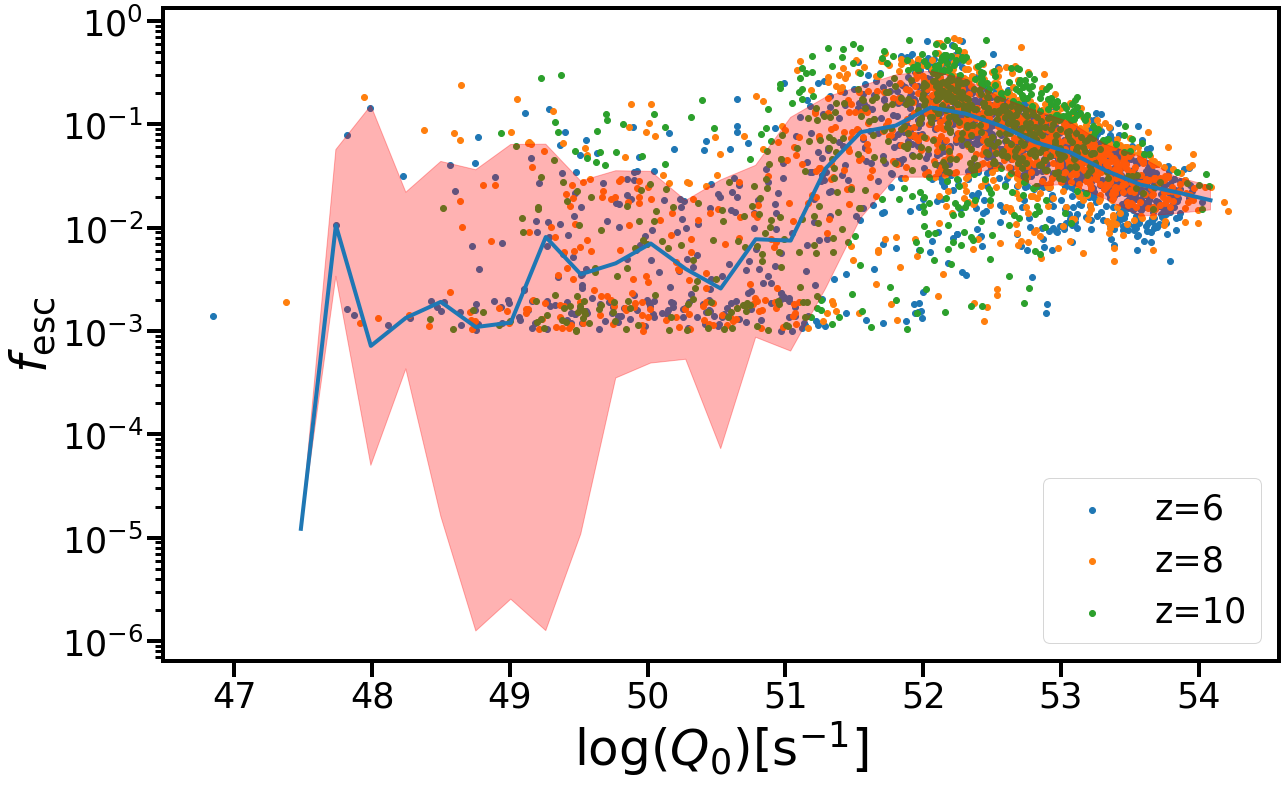

In [59]:
plot_spectra_comparison(dfs, 'Q0', y_prop='f_esc', labels=None, x_label=x_label, y_label=None, 
                            x_scale='log', y_scale='log', bins=30, threshold=1e-3, 
                            color_by_red=True, scatter=True, save=True)

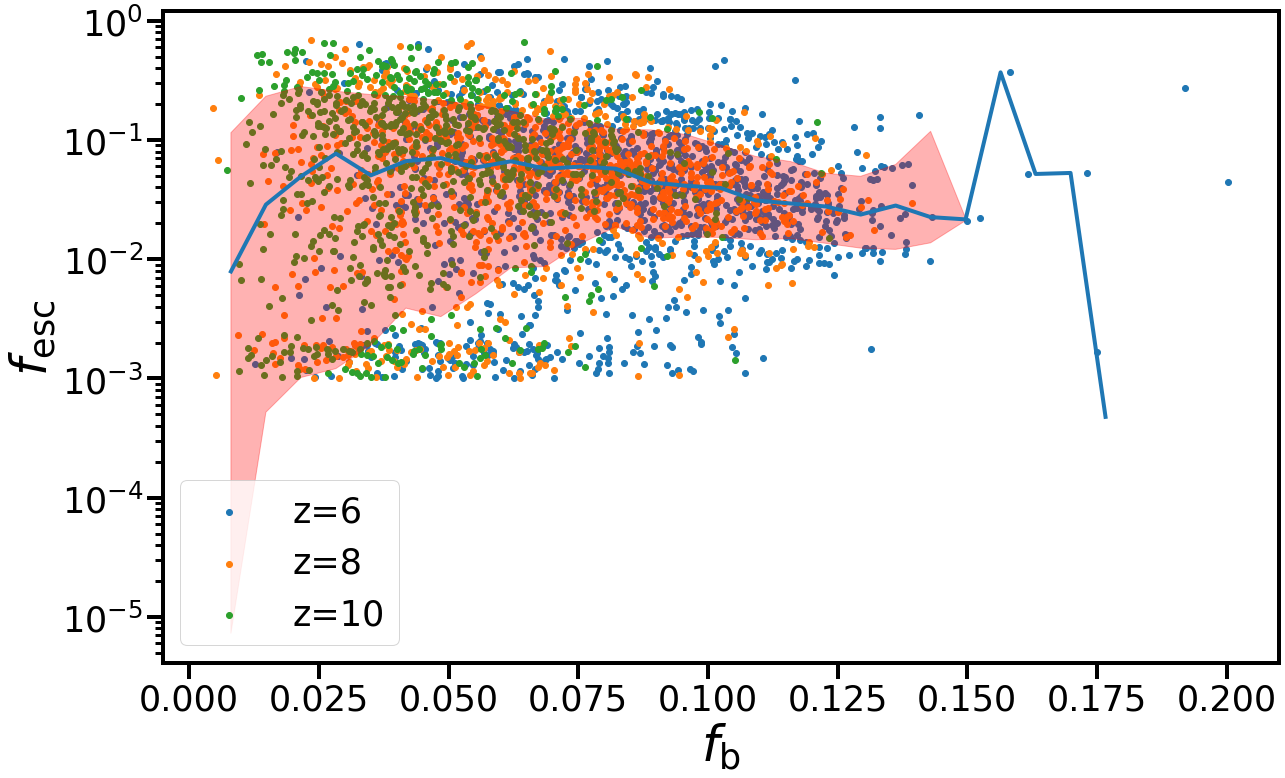

In [60]:
plot_spectra_comparison(dfs, 'FractionGas', y_prop='f_esc', labels=None, x_label=r'$f_\mathrm{b}$', y_label=None, 
                            x_scale='lin', y_scale='log', bins=30, threshold=1e-3, 
                            color_by_red=True, scatter=True, save=True)